# Poor Confidence Analysis
This analysis aims to improve the NER model by studying the predictions done by the model. This is done firstly by identifying the weakness or limitations discovered from the prediction results. So, by looking at the outputs, the confidence score can be the area of focus for this analysis.

The idea of this analysis is to find out if the low confidence scores are justifiable. For example, is the confidence score related to the volume of the dataset, frequency of the labels, or word rarity? This analysis covers the:
1. label frequency
2. text frequency
3. confidence score distribution
4. text length
5. text complexity

This can be determined by answering these questions:
1. Is there a correlation between label frequency and confidence scores?    (`label`)
2. Are low-confidence predictions associated with text frequency/rarity?    (`text`)
3. Do certain label types show systematic confidence patterns?              (`label`)
4. Is confidence score correlated with text length?                         (`text`)
5. Is confidence score correlated with complexity?                          (`text`)

Based on these questions, 

* If low scores correlate with rare labels: Augment training data for underrepresented classes.
* If low scores correlate with rare words: Add domain-specific vocabulary for training.
* If low scores are consistent with certain label group: Focused annotation to cator specific labelings.

If all are unclear: Review model architecture or hyperparameter tuning

-------------
------
## Data Pre-processing

#### Import Libraries

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats             # correlation

#### Load Dataset

In [140]:
# load csv
df = pd.read_csv(r'..\prediction\results_first_line.csv')
df.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [85]:
df.info

<bound method DataFrame.info of          start      end                text   label     score
0            0        5               polis     ORG  0.904411
1           23       31            siasatan   EVENT  0.733970
2           32       39             program     ORG  0.677047
3           40       45               ehati     ORG  0.682098
4           46       52              wanita  PERSON  0.935187
...        ...      ...                 ...     ...       ...
24290  1484116  1484123             sarawak     LOC  0.679316
24291  1484139  1484157  mustafa kamal gani  PERSON  0.872470
24292  1484194  1484201             peniaga  PERSON  0.644195
24293  1484206  1484216          suri rumah  PERSON  0.686967
24294  1484237  1484245            64 tahun    TIME  0.678553

[24295 rows x 5 columns]>

In [86]:
# normalize text
df['text'] = df['text'].str.lower()
df.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [87]:
# duplicates
df.drop_duplicates().head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


-------------
--------
## Exploratory Data Analysis
This part aims to explore the dataset in hopes to uncover hidden perspectives.

#### Label Distribution

In [88]:
df.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [89]:
# label distribution
df['label'].value_counts()

label
ORG            5930
PERSON         5437
LOC            5181
EVENT          1685
GPE            1278
PRODUCT        1242
TIME           1096
MONEY           738
QUANTITY        511
LAW             459
WORK_OF_ART     247
PERCENT         209
CARDINAL        139
NORP             79
FAC              62
ORDINAL           2
Name: count, dtype: int64

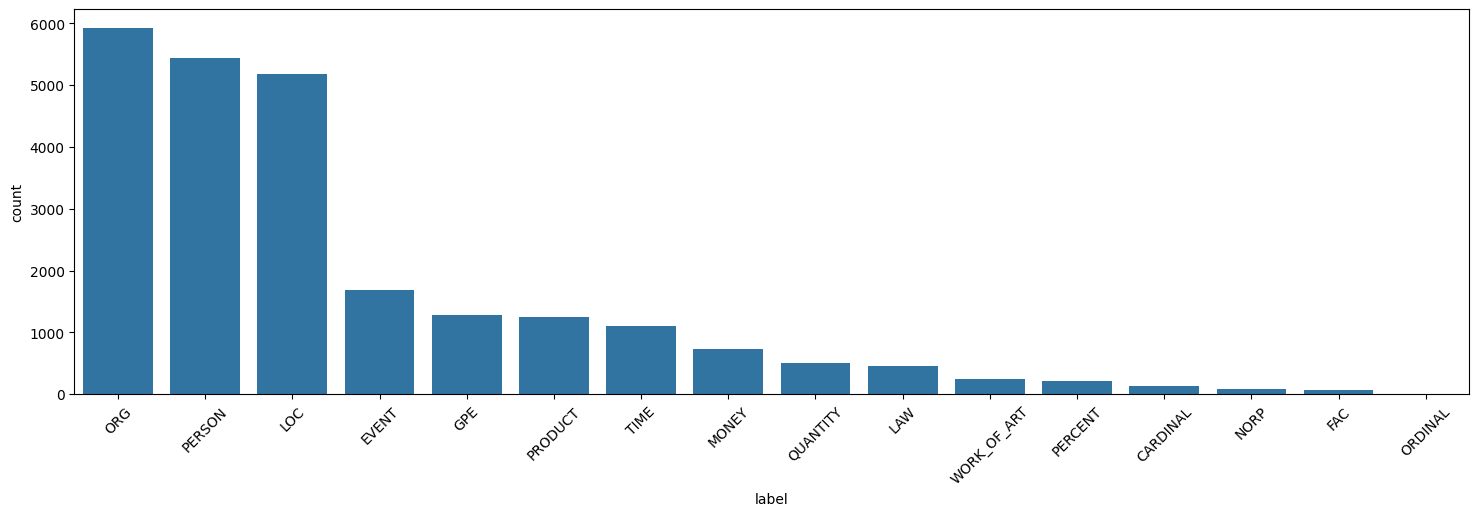

In [90]:
# visualize
label_freq = df['label'].value_counts().index

plt.figure(figsize=(18,5))
sns.countplot(x=df['label'],data=df, order=label_freq)
plt.xticks(rotation=45)
plt.show()

From this graph, it is safe to assume that the high-frequency labels are the 3 highest, while the others are teh low-frequency labels. This is because the gap between the third and the fourth highest is relatively big (1500 vs 500), when compared to other inter-label gaps.

#### High and Low Frequency Labels

In [91]:
# overview
df.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [92]:
# drop columns
freq = df.drop(['start','end','text'], axis=1)
freq.head()

,label,score
0,ORG,0.904411
1,EVENT,0.733970
2,ORG,0.677047
3,ORG,0.682098
4,PERSON,0.935187


In [93]:
# list labels
freq['label'].unique()

array(['ORG', 'EVENT', 'PERSON', 'TIME', 'LOC', 'PRODUCT', 'GPE',
       'QUANTITY', 'LAW', 'MONEY', 'WORK_OF_ART', 'PERCENT', 'CARDINAL',
       'ORDINAL', 'NORP', 'FAC'], dtype=object)

In [94]:
# split into higher and lower frequency groups
high_freq_label = ['PERSON','ORG','LOC']
low_freq_label = ['PRODUCT', 'QUANTITY', 'EVENT', 'GPE',
       'CARDINAL', 'TIME', 'LAW', 'MONEY', 'PERCENT', 'WORK_OF_ART',
       'NORP', 'FAC', 'ORDINAL']

freq_high = freq[freq['label'].isin(high_freq_label)]
freq_low = freq[freq['label'].isin(low_freq_label)]

#### Confidence Score Disctribution

In [95]:
# get mean confidence score
conf = df.groupby('label')['score'].mean().reset_index()
conf = conf.sort_values('score', ascending=False)

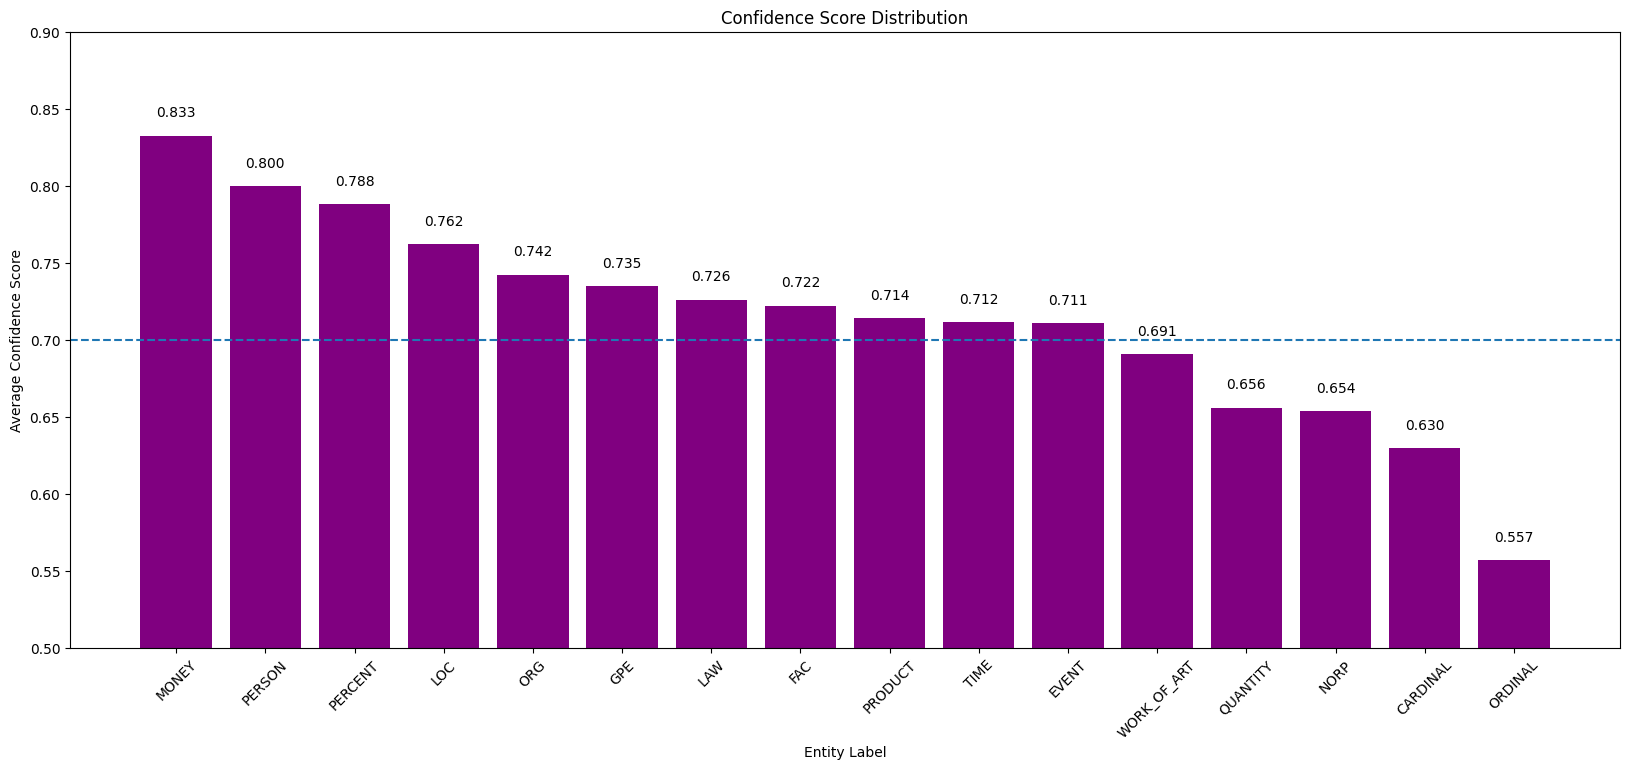

In [96]:
# visualize
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 1, 1) 
bars = ax.bar(conf['label'], conf['score'], color='purple')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            height + 0.01, f'{height:.3f}',
            ha='center', va='bottom', fontsize=10)

ax.set_title('Confidence Score Distribution')
ax.set_xlabel('Entity Label')
ax.set_ylabel('Average Confidence Score')
ax.set_ylim(0.5, 0.9)
ax.axhline(y=0.7,linestyle='--')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()


Based on this distribution, there are 5 labels that are considered to be low-confidence.

#### Confidence Scores in High and Low Frequency Labels

In [97]:
# get mean score
label_score_mean_high = freq_high.groupby('label')['score'].mean().reset_index()
label_score_mean_low = freq_low.groupby('label')['score'].mean().reset_index()

In [98]:
# sort mean score
label_score_mean_high = label_score_mean_high.sort_values('score', ascending=False)
label_score_mean_low = label_score_mean_low.sort_values('score', ascending=False)

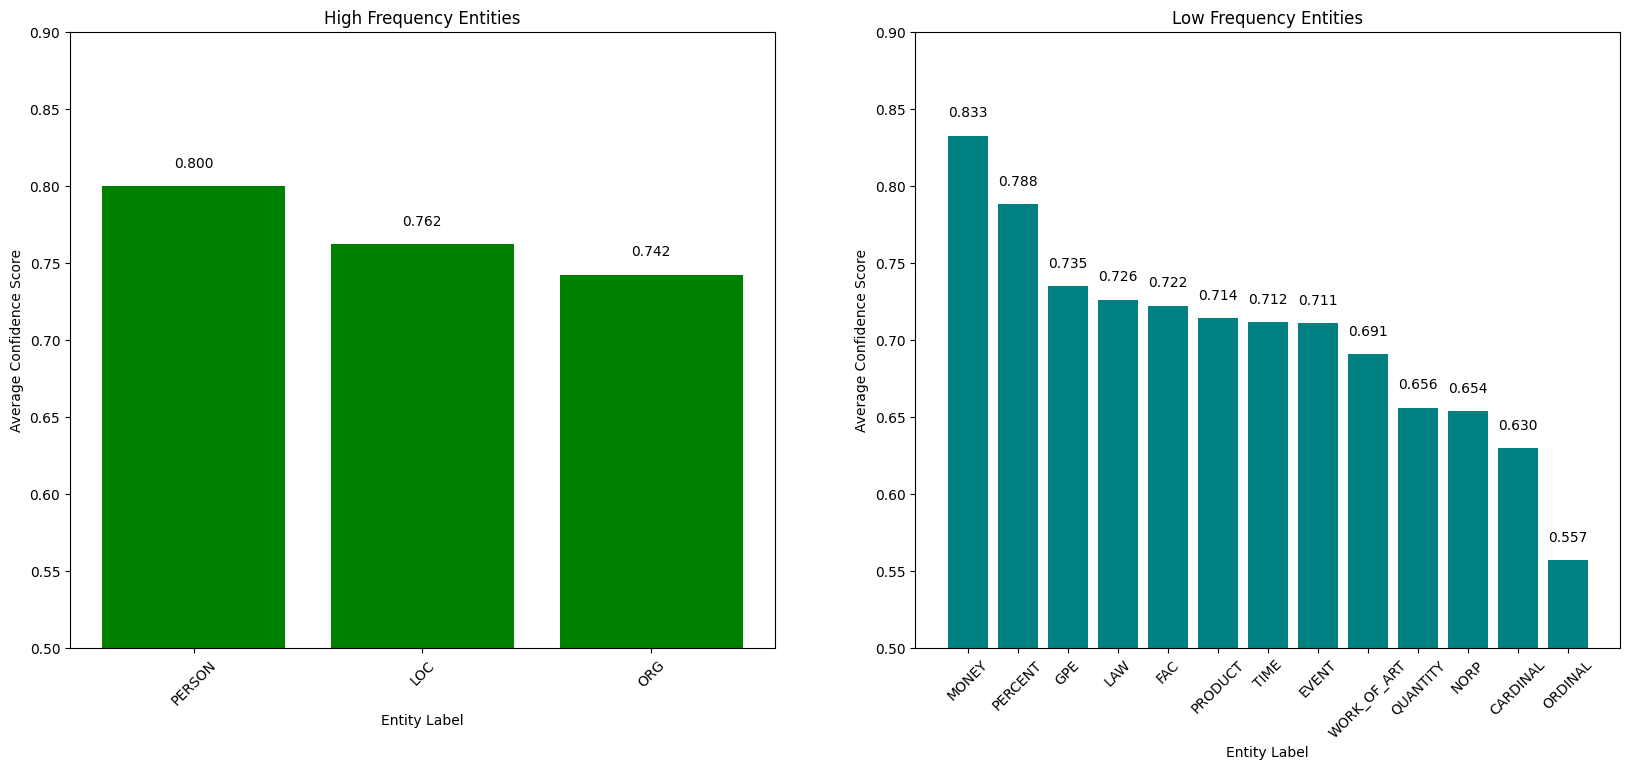

In [99]:
# visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# high frequency labels
bars1 = ax1.bar(label_score_mean_high['label'], 
               label_score_mean_high['score'],
               color='green')

# labeling
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax1.set_title('High Frequency Entities')
ax1.set_xlabel('Entity Label')
ax1.set_ylabel('Average Confidence Score')
ax1.set_ylim(0.5, 0.9)
ax1.tick_params(axis='x', rotation=45)

# low frequency labels
bars2 = ax2.bar(label_score_mean_low['label'], 
               label_score_mean_low['score'],
               color='teal')

# labeling
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax2.set_title('Low Frequency Entities')
ax2.set_xlabel('Entity Label')
ax2.set_ylabel('Average Confidence Score')
ax2.set_ylim(0.5, 0.9)
ax2.tick_params(axis='x', rotation=45)

# display
plt.tight_layout
plt.show()

Based on these graphs, the lowest confidence score for the high-frequency labels is around 76%, while the highest confidence score for the low-frequency labels is around 82%. This means that even if the label is relatively rare, the confidence score can still be high. Even so, it cannot be a certain that there is no correlation between the label rarity and the confidence score. Therefore, a correlation analysis can be done to further confirm this.

#### Low Rarity Texts

In [100]:
# overview
df.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [101]:
# text frequency
text_freq = df['text'].value_counts().reset_index() 
text_freq

,text,count
0,utusan malaysia,634
1,kuala lumpur,376
2,malaysia,374
3,polis,197
4,petaling jaya,137
...,...,...
9573,peralihan endemik,1
9574,mesyuarat agung tahunan,1
9575,yayasan peneraju pendidikan bumiputera,1
9576,dunkin’ donuts,1


In [102]:
# texts that appeared only once
text_low = text_freq[text_freq['count'] == 1]
text_low

,text,count
3201,64 tahun,1
3202,rumput,1
3203,lelaki direman,1
3204,wan kamaruzaman,1
3205,hong hong san,1
...,...,...
9573,peralihan endemik,1
9574,mesyuarat agung tahunan,1
9575,yayasan peneraju pendidikan bumiputera,1
9576,dunkin’ donuts,1


From this, there are about 4000 texts that appeared only once. That's more than half of the whole dataset (6000 texts)! This is also while excluding the texts that appeared only twice or thrice.

However, this is to be expected since texts with unique nomenclature or numbers might be a factor to this phenomenon. 

#### Distribution of Confidence Score in Low Rarity Texts

In [103]:
# overview
df.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [104]:
# get score for low rarity texts
text_conf = df.groupby('text')['score'].mean().reset_index()  # get mean confidence score

text_low_conf = pd.merge(text_freq, text_conf, on='text')
text_low_conf = text_low_conf[text_low_conf['count'] == 1]
text_low_conf.sort_values('score',ascending=False)

,text,count,score
3298,harvey elliott,1,0.995564
3527,novak djokovic,1,0.995105
3453,mimi fly,1,0.994010
9564,muhammad yunus,1,0.993510
3275,siti saleha,1,0.993173
...,...,...,...
4869,calon mentua,1,0.500297
3923,sendu,1,0.500237
7804,kampung glam,1,0.500207
4816,bekalan makanan,1,0.500191


Here, we can see that the rare texts has the confidence score at both high and low ends.

In [105]:
score_low = df[df['score'] < 0.7]
score_low.sort_values('score',ascending=False)

,start,end,text,label,score
15007,673512,673524,pelitup muka,PRODUCT,0.699989
21224,1236143,1236150,kemboja,GPE,0.699988
1481,25764,25767,ceo,PERSON,0.699948
14108,608641,608650,pertemuan,EVENT,0.699946
2731,47649,47664,utusan malaysia,ORG,0.699939
...,...,...,...,...,...
7242,166375,166381,gambar,WORK_OF_ART,0.500137
2986,52444,52449,kubur,ORG,0.500113
12799,488560,488567,majikan,ORG,0.500094
20529,1157093,1157097,ajaz,PERSON,0.500062


There are about 5000 texts that has low confidence scores.

#### Distribution of Text Lengths

In [106]:
txt_len = df.copy()
txt_len['chara'] = df['text'].str.len()
txt_len

,start,end,text,label,score,chara
0,0,5,polis,ORG,0.904411,5
1,23,31,siasatan,EVENT,0.733970,8
2,32,39,program,ORG,0.677047,7
3,40,45,ehati,ORG,0.682098,5
4,46,52,wanita,PERSON,0.935187,6
...,...,...,...,...,...,...
24290,1484116,1484123,sarawak,LOC,0.679316,7
24291,1484139,1484157,mustafa kamal gani,PERSON,0.872470,18
24292,1484194,1484201,peniaga,PERSON,0.644195,7
24293,1484206,1484216,suri rumah,PERSON,0.686967,10


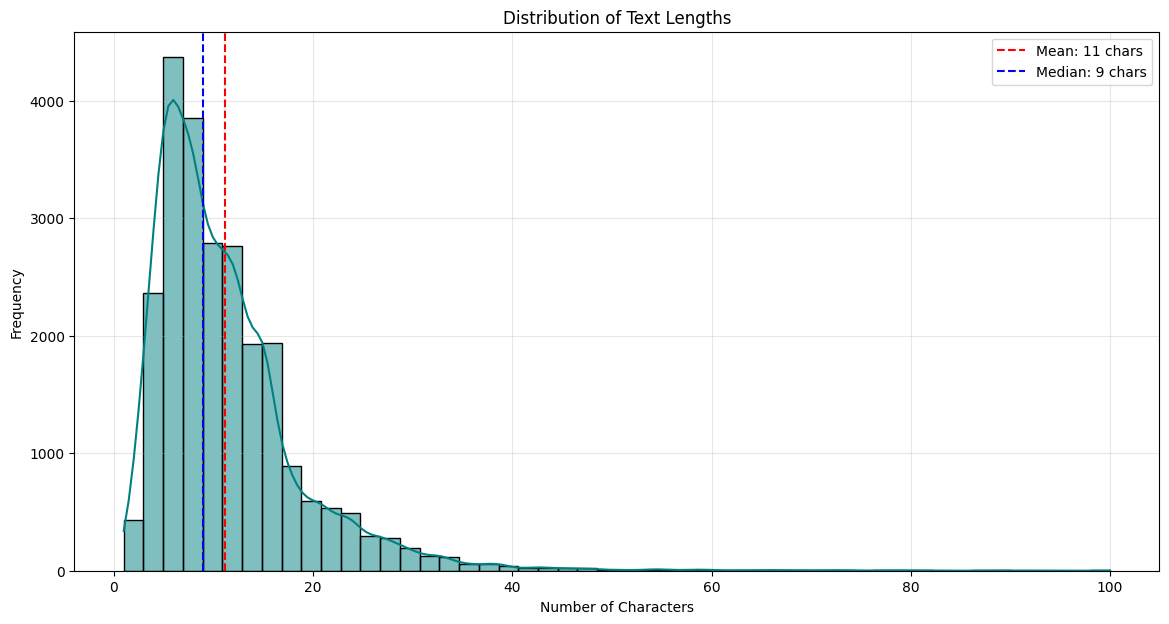

In [107]:
# distribution of text length
plt.figure(figsize=(14, 7))

# histogram
sns.histplot(txt_len['chara'], bins=50, kde=True, color='teal')

# mean line
mean_length = txt_len['chara'].mean()
plt.axvline(mean_length, color='red', linestyle='--', 
            label=f'Mean: {mean_length:.0f} chars')

# median line
median_length = txt_len['chara'].median()
plt.axvline(median_length, color='blue', linestyle='--', 
            label=f'Median: {median_length:.0f} chars')

# plot
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

This distribution histogram is right-skewed. It comprises of mostly short texts.

--------------
--------------
## Data Analysis

-------------
### Q1: Is there a correlation between label frequency and confidence scores?
Study on the mean confidence scores and label frequency correlation. This is to see if high frequency means high confidence score, or vice versa.

#### Data Preparation

In [108]:
# overview
df.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [109]:
# create new dataset
q1_label = df['label'].value_counts().reset_index()         # get label frequency
q1_conf = df.groupby('label')['score'].mean().reset_index() # get mean confidence score

q1_label_analysis = pd.merge(q1_label, q1_conf, on='label')
q1_label_analysis.sort_values('score',ascending=False)

,label,count,score
7,MONEY,738,0.832831
1,PERSON,5437,0.799991
11,PERCENT,209,0.788109
2,LOC,5181,0.762464
0,ORG,5930,0.742492
4,GPE,1278,0.735221
9,LAW,459,0.726265
14,FAC,62,0.722408
5,PRODUCT,1242,0.714294
6,TIME,1096,0.711952


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship
3. Shapiro-Wilk test - to determine if its normally distributed

**Null hypothesis:**\
There is no correlation between label frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between label frequency and confidence scores.

In [110]:
# pearson
q1_pearson_corr, q1_p_value = stats.pearsonr(
    q1_label_analysis['count'],
    q1_label_analysis['score']
)

# spearman
q1_spearman_rho, q1_p_spearman = stats.spearmanr(
    q1_label_analysis['count'],
    q1_label_analysis['score']
)

# normality test
q1_shapiro_test = stats.shapiro(q1_label_analysis['score'])

In [111]:
print(f"Spearman rho    : {q1_spearman_rho:.3f}")
print(f"Spearman p      : {q1_p_spearman:.4f}\n")
print(f"Pearson r       : {q1_pearson_corr:.3f}")
print(f"Pearson p       : {q1_p_value:.4f}\n")
print(f"Shapiro-Wilk W  : {q1_shapiro_test[0]:.3f}")
print(f"Shapiro-Wilk p  : {q1_shapiro_test[1]:.4f}\n")

Spearman rho    : 0.568
Spearman p      : 0.0218

Pearson r       : 0.451
Pearson p       : 0.0792

Shapiro-Wilk W  : 0.971
Shapiro-Wilk p  : 0.8523



Based on these results:
* There is a significant (p < 0.05) strong positive monotonic relationship (rho > 0.6). This means that as label frequency increases, confidence scores consistently increase, but not necessarily in a straight-line pattern - Spearman correlation test
* There is a significant (p < 0.05) moderate positive linear relationship (r > 0.4, r < 0.6). This means that higher frequency moderately predicts higher confidence in a linear pattern. - Pearson correlation test
* Since the rho > r, the monotonic relationship is stronger than the linear relationship. This means that even though higher frequency boosts the confidence score, the boost will decrease with higher frequency.
* Since both of these tests are significant, the results are not random.
* The data is normally distributed (p > 0.05). - Shapiro-Wilk test

Therefore, we reject the null hypothesis.

For fine-tuning, training data that focuses on the low-frequency labels can be used for augmentation.

In [112]:
# filter low-frequency labels in main dataset
ft_q1 = df[df['label'].isin(low_freq_label)]
ft_q1 = ft_q1[ft_q1['score'] < 0.7]
ft_q1.sort_values('score')

,start,end,text,label,score
7242,166375,166381,gambar,WORK_OF_ART,0.500137
3859,69832,69847,bekalan makanan,PRODUCT,0.500191
859,14022,14026,maut,EVENT,0.500214
823,13532,13536,maut,EVENT,0.500214
19123,1039971,1039990,kejohanan sukan sea,EVENT,0.500328
...,...,...,...,...,...
20147,1122254,1122264,rm210 juta,MONEY,0.699717
13291,540111,540131,separuh masa pertama,TIME,0.699884
14108,608641,608650,pertemuan,EVENT,0.699946
21224,1236143,1236150,kemboja,GPE,0.699988


------------
### Q2: Are low-confidence predictions correlated with text frequency/rarity?
Study on the low confidence scores and text frequency. This is to see if lower rarity means lower confidence score, or vice versa.

#### Data Preparation

In [113]:
# overview
df.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [114]:
# create new dataset
q2_text = df['text'].value_counts().reset_index()           # get text frequency
q2_conf = df.groupby('text')['score'].mean().reset_index()  # get mean confidence score

q2_text_analysis = pd.merge(q2_text, q2_conf, on='text')
q2_text_analysis

,text,count,score
0,utusan malaysia,634,0.712544
1,kuala lumpur,376,0.863326
2,malaysia,374,0.731563
3,polis,197,0.777792
4,petaling jaya,137,0.751199
...,...,...,...
9573,peralihan endemik,1,0.611271
9574,mesyuarat agung tahunan,1,0.918898
9575,yayasan peneraju pendidikan bumiputera,1,0.951935
9576,dunkin’ donuts,1,0.883809


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship

**Null hypothesis:**\
There is no correlation between text frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between text frequency and confidence scores.

In [115]:
# pearson
q2_pearson_corr, q2_p_value = stats.pearsonr(
    q2_text_analysis['count'],
    q2_text_analysis['score']
)

# spearman
q2_spearman_rho, q2_p_spearman = stats.spearmanr(
    q2_text_analysis['count'],
    q2_text_analysis['score']
)

In [116]:
print(f"Spearman rho: {q2_spearman_rho:.3f}")
print(f"Spearman p: {q2_p_spearman:.4f}\n")
print(f"Pearson r: {q2_pearson_corr:.3f}")
print(f"Pearson p: {q2_p_value:.4f}\n")

Spearman rho: 0.032
Spearman p: 0.0017

Pearson r: 0.007
Pearson p: 0.4768



Based on these results:
* There is a significant (p < 0.05) but negligible monotonic relationship (rho < 0.1). This means that there is no meaningful relationship between text and confidence score. - Spearman correlation test
* There is no significant (p > 0.05) linear relationship (r < 0.1). This means that there is no evidence of linear relationship between text and confidence score. - Pearson correlation test

Therefore, we do not reject the null hypothesis.

The fine-tuning should be aimed at other factors instead.

This further justifies the EDA,  where the confidence scores are covered from both high and low ends from the texts, despite the rarity of the texts.

------------
### Q3: Do certain label types show systematic confidence patterns?
Analyze low confidence score distributions per label type. This is to see whether certain labels are under-trained.

#### Data Preparation

In [117]:
# overview
df.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [118]:
# sort and filter score < 0.7
q3 = df.sort_values('score', ascending=False)
q3 = q3[q3['score'] < 0.7]
q3

,start,end,text,label,score
15007,673512,673524,pelitup muka,PRODUCT,0.699989
21224,1236143,1236150,kemboja,GPE,0.699988
1481,25764,25767,ceo,PERSON,0.699948
14108,608641,608650,pertemuan,EVENT,0.699946
2731,47649,47664,utusan malaysia,ORG,0.699939
...,...,...,...,...,...
7242,166375,166381,gambar,WORK_OF_ART,0.500137
2986,52444,52449,kubur,ORG,0.500113
12799,488560,488567,majikan,ORG,0.500094
20529,1157093,1157097,ajaz,PERSON,0.500062


In [119]:
# number of labels
print(f"number of labels with low-scores    : {len(q3['label'].unique())}")
print(f"number of labels on main            : {len(df['label'].unique())}")

number of labels with low-scores    : 16
number of labels on main            : 16


It seems that there are low-confidence scores for all  types of lables. However, based on our EDA, the lables that has low-average confidence scores are the FAC, NORP, QUANTITY, CARDINAL, and ORDINAL (5 labels). This might be because of outliers in each label type. But to be sure, the weight of the low confidence scores and high confidence scores can be measured for each label. Since the number of the scores cannot be compared because of relative frequencies, percentages can be used for the comparison. 

#### Compare Confidence Score of Individual Labels
Get horizontal bar chart for each label (16 bar charts), with confidence score of 0.7 as the sperator for each chart.

In [120]:
# get back full dataset
q3 = df
q3.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [121]:
# get number labels of high and low confidence
q3_conf = q3.groupby('label')['score'].agg(
    high_conf=lambda x: (x >= 0.7).sum(),
    low_conf=lambda x: (x < 0.7).sum(),
    total='count'
).reset_index()
q3_conf

,label,high_conf,low_conf,total
0,CARDINAL,28,111,139
1,EVENT,847,838,1685
2,FAC,35,27,62
3,GPE,767,511,1278
4,LAW,256,203,459
5,LOC,3478,1703,5181
6,MONEY,610,128,738
7,NORP,27,52,79
8,ORDINAL,0,2,2
9,ORG,3615,2315,5930


In [122]:
# get percentages
q3_conf['high_conf_pct'] = (q3_conf['high_conf'] / q3_conf['total'] * 100).round(1)
q3_conf['low_conf_pct'] = (q3_conf['low_conf'] / q3_conf['total'] * 100).round(1)
q3_conf

,label,high_conf,low_conf,total,high_conf_pct,low_conf_pct
0,CARDINAL,28,111,139,20.1,79.9
1,EVENT,847,838,1685,50.3,49.7
2,FAC,35,27,62,56.5,43.5
3,GPE,767,511,1278,60.0,40.0
4,LAW,256,203,459,55.8,44.2
5,LOC,3478,1703,5181,67.1,32.9
6,MONEY,610,128,738,82.7,17.3
7,NORP,27,52,79,34.2,65.8
8,ORDINAL,0,2,2,0.0,100.0
9,ORG,3615,2315,5930,61.0,39.0


In [123]:
# Sort by high confidence percentage (descending)
q3_conf = q3_conf.sort_values('high_conf_pct', ascending=False)
q3_conf

,label,high_conf,low_conf,total,high_conf_pct,low_conf_pct
6,MONEY,610,128,738,82.7,17.3
10,PERCENT,166,43,209,79.4,20.6
11,PERSON,3990,1447,5437,73.4,26.6
5,LOC,3478,1703,5181,67.1,32.9
9,ORG,3615,2315,5930,61.0,39.0
3,GPE,767,511,1278,60.0,40.0
2,FAC,35,27,62,56.5,43.5
4,LAW,256,203,459,55.8,44.2
12,PRODUCT,658,584,1242,53.0,47.0
14,TIME,575,521,1096,52.5,47.5


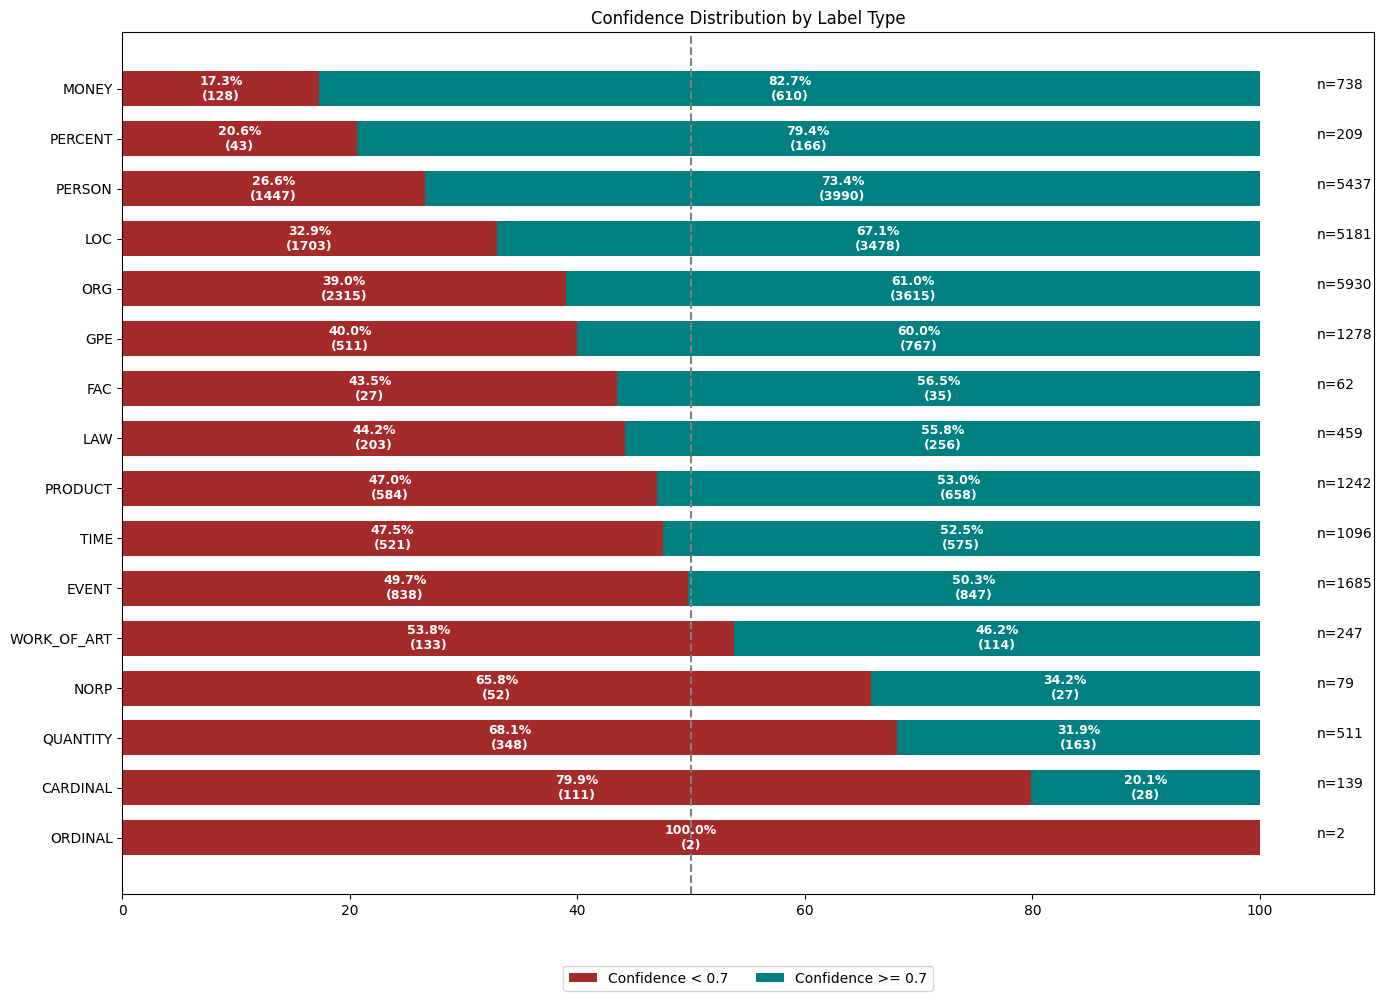

In [124]:
# visualize
plt.figure(figsize=(14, 10))
y_pos = np.arange(len(q3_conf))
bar_height = 0.7

# stacked horizontal bar charts
low_bars = plt.barh(y_pos, q3_conf['low_conf_pct'], 
                    height=bar_height, color='brown', label='Confidence < 0.7')
high_bars = plt.barh(y_pos, q3_conf['high_conf_pct'], 
                     left=q3_conf['low_conf_pct'], 
                     height=bar_height, color='teal', label='Confidence >= 0.7')

# annotations
for i, (low_pct, high_pct, total) in enumerate(zip(q3_conf['low_conf_pct'], 
                                                   q3_conf['high_conf_pct'], 
                                                   q3_conf['total'])):
    # low confidence scores
    if low_pct > 1:     # to ensure space
        plt.text(low_pct/2, i, 
                 f'{low_pct:.1f}%\n({int(q3_conf["low_conf"].iloc[i])})', 
                 ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    
    # high confidence scores
    if high_pct > 1:    # to ensure space 
        plt.text(q3_conf['low_conf_pct'].iloc[i] + high_pct/2, i, 
                 f'{high_pct:.1f}%\n({int(q3_conf["high_conf"].iloc[i])})', 
                 ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    
    # total
    plt.text(105, i, f'n={total}')

    # line at 50%

# plot
plt.axvline(x=50, color='grey', linestyle='--')
plt.gca().invert_yaxis()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=2)
plt.yticks(y_pos, q3_conf['label'])
plt.title('Confidence Distribution by Label Type')
plt.xlim(0, 110)
plt.tight_layout()
plt.show()

There are a few key points that can be taken away from this chart, but to break it down further:

Based on >= 50% high confidence score coverage(10 labels):
* Even though 'MONEY','PERCENT', 'GPE', 'LAW', 'TIME', 'PRODUCT', and 'EVENT' are considered to be low-frequency labels, based on the EDA, they have high confidence score coverage.
* The high-frequency labels, 'ORG', 'PERSON', and 'LOC' all have high confidence score coverage.
* The 'PERCENT' may be an outlier, because despite having the lowest number of labels in this category, it is has the second highest high confidence score coverage. This might be because of the simplicity/less variability of the annotation i.e. the symbol '%' is used as the indication for the label.

Based on < 50% high confidence score coverage(6 labels):
* All of the labels in these category are the low-frequency labels based on the EDA.
* The ' QUANTITY' label may in an outlier, because despite having the highest number of labels, about double from the second highest, it is has a poor high confidence score coverage. This might be because of the variability of the annotation, from being numbers.

From this, a label-focused annotation can be done for the fine-tuning:
* 'ORDINAL', 'CARDINAL', 'QUANTITY', 'NORP', 'WORK_OF_ART', and 'EVENT' should be the labels of focus.

In [125]:
# get low high confidence covergage labels with low confidence
low_high_cov_label = ['ORDINAL', 'CARDINAL', 'QUANTITY', 'NORP', 'WORK_OF_ART', 'EVENT']

ft_q3 = df[df['label'].isin(low_high_cov_label)]
ft_q3 = ft_q3[ft_q3['score'] < 0.7]
ft_q3.sort_values('score')

,start,end,text,label,score
7242,166375,166381,gambar,WORK_OF_ART,0.500137
859,14022,14026,maut,EVENT,0.500214
823,13532,13536,maut,EVENT,0.500214
19123,1039971,1039990,kejohanan sukan sea,EVENT,0.500328
19398,1058353,1058392,majlis memetrai memorandum persefahaman,EVENT,0.500330
...,...,...,...,...,...
18180,963909,963933,sukan olimpik paris 2024,EVENT,0.699121
11203,355137,355152,kebakaran hutan,EVENT,0.699160
17074,862820,862834,modus operandi,WORK_OF_ART,0.699347
13338,543042,543108,"haji.\n\ndalam pada itu, jurucakap komander ka...",EVENT,0.699439


-----------
### Q4: Is confidence score correlated with text length or complexity?
Find the correlation between length of texts and confidence scores.

#### Data Preparation

In [126]:
# overview
df.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [127]:
# get characters
q4_chara_analysis = txt_len.copy()
q4_chara_analysis

,start,end,text,label,score,chara
0,0,5,polis,ORG,0.904411,5
1,23,31,siasatan,EVENT,0.733970,8
2,32,39,program,ORG,0.677047,7
3,40,45,ehati,ORG,0.682098,5
4,46,52,wanita,PERSON,0.935187,6
...,...,...,...,...,...,...
24290,1484116,1484123,sarawak,LOC,0.679316,7
24291,1484139,1484157,mustafa kamal gani,PERSON,0.872470,18
24292,1484194,1484201,peniaga,PERSON,0.644195,7
24293,1484206,1484216,suri rumah,PERSON,0.686967,10


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship

**Null hypothesis:**\
There is no correlation between text length and confidence scores.

**Alternative hypothesis:**\
There is a correlation between text length and confidence scores.

In [128]:
# pearson
q4_pearson_corr, q4_p_value = stats.pearsonr(
    q4_chara_analysis['chara'],
    q4_chara_analysis['score']
)

# spearman
q4_spearman_rho, q4_p_spearman = stats.spearmanr(
    q4_chara_analysis['chara'],
    q4_chara_analysis['score']
)

In [129]:
# display
print(f"Spearman rho: {q4_spearman_rho:.3f}")
print(f"Spearman p: {q4_p_spearman:.4f}\n")
print(f"Pearson r: {q4_pearson_corr:.3f}")
print(f"Pearson p: {q4_p_value:.4f}\n")

Spearman rho: 0.102
Spearman p: 0.0000

Pearson r: 0.058
Pearson p: 0.0000



Based on these readings,

There is a highly significant (p < 0.05) weak positive monotonic and linear relationship (rho < 0.4, r < 0.4). This means that the effects of the text length to confidence score is negligible.

Therefore, we reject the null hypothesis. However, the relationship has no practical importance.

So, no fine-tuning can be uased by the text lengths.

-----------
### Q5: Is confidence score correlated with text complexity?
Find the correlation between the complexity of texts and confidence scores.

#### Data Preparation

In [130]:
# overview
df.head()

,start,end,text,label,score
0,0,5,polis,ORG,0.904411
1,23,31,siasatan,EVENT,0.733970
2,32,39,program,ORG,0.677047
3,40,45,ehati,ORG,0.682098
4,46,52,wanita,PERSON,0.935187


In [131]:
# feature selection
q5_complex_analysis = df[['text', 'score']].copy()
q5_complex_analysis

,text,score
0,polis,0.904411
1,siasatan,0.733970
2,program,0.677047
3,ehati,0.682098
4,wanita,0.935187
...,...,...
24290,sarawak,0.679316
24291,mustafa kamal gani,0.872470
24292,peniaga,0.644195
24293,suri rumah,0.686967


In [132]:
# text processing
text = q5_complex_analysis['text']
words = text.str.split()
word_count = words.str.len()
word_count.sort_values()

24280     1
24279     1
21        1
19        1
18        1
         ..
21668    12
18153    12
21219    12
11860    12
23433    12
Name: text, Length: 24295, dtype: int64

In [133]:
# word diversity
word_diversity = words.apply(set).str.len() / word_count
word_diversity.sort_values()

24237    0.666667
20814    0.666667
13611    0.666667
16025    0.666667
14186    0.666667
           ...   
24291    1.000000
24292    1.000000
24293    1.000000
24294    1.000000
0        1.000000
Name: text, Length: 24295, dtype: float64

In [134]:
# average word length
avg_word_length = words.str.join(' ').str.len() / word_count
avg_word_length.sort_values()

664       1.0
746       1.0
848       1.0
862       1.0
826       1.0
         ... 
5075     19.0
10643    21.0
18483    21.0
18511    21.0
18519    21.0
Name: text, Length: 24295, dtype: float64

In [135]:
# special character ratio
special_char_ratio = text.str.count(r'[^\w\s]') / text.str.len()
special_char_ratio.sort_values()

16       0.0
24273    0.0
24274    0.0
24275    0.0
24276    0.0
        ... 
14831    0.5
14825    0.5
14827    0.5
14833    0.5
4174     0.5
Name: text, Length: 24295, dtype: float64

In [136]:
# average complexity
q5_complex_analysis = q5_complex_analysis.assign(
    complexity=(
        word_diversity + 
        avg_word_length / 10 + 
        special_char_ratio
    ) / 3  
)

In [137]:
# display
q5_complexity = q5_complex_analysis[['text', 'score', 'complexity']].sort_values('complexity')
q5_complexity.sort_values('complexity')

,text,score,complexity
7334,bea sobar bea,0.686007,0.366667
8663,bea sobar bea,0.704599,0.366667
24237,hong hong san,0.669007,0.366667
7735,bae sobar bae,0.763922,0.366667
7802,bae sobar bae,0.763922,0.366667
...,...,...,...
5075,malaysia-azerbaijan,0.626946,0.984211
10643,pengkritik-pengkritik,0.622961,1.049206
18483,universiti-universiti,0.501680,1.049206
18519,kontraktor-kontraktor,0.637085,1.049206


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship

**Null hypothesis:**\
There is no correlation between text complexity and confidence scores.

**Alternative hypothesis:**\
There is a correlation between text complexity and confidence scores.

In [138]:
# pearson
q5_pearson_corr, q5_p_value = stats.pearsonr(
    q5_complex_analysis['complexity'],
    q5_complex_analysis['score']
)

# spearman
q5_spearman_rho, q5_p_spearman = stats.spearmanr(
    q5_complex_analysis['complexity'],
    q5_complex_analysis['score']
)

In [139]:
# display
print(f"Spearman rho: {q5_spearman_rho:.3f}")
print(f"Spearman p: {q5_p_spearman:.4f}\n")
print(f"Pearson r: {q5_pearson_corr:.3f}")
print(f"Pearson p: {q5_p_value:.4f}\n")

Spearman rho: 0.007
Spearman p: 0.2619

Pearson r: 0.015
Pearson p: 0.0177



From this: 
* There is a not significant (p > 0.05) positive monotonic relationship (rho < 0.4). - Spearman correlation test
* There is a significant (p < 0.05) positive weak linear relationship (r < 0.4). - Pearson correlation test